# golive3

Extend the number of path/row elements out to eight, all with the same UTM lat/lon zone. (Otherwise coordinates
will start getting crossed.)

In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### UTM zone stuff

Coordinates are Paths 60, 61, 62, 63, 64, 65 x Rows 17 and 18. However the `x` and `y` coordinates are degenerate
from one to another when the UTM zone changes, specifically in longitude. This we can pull from a dataset using 
this function: 


```
def GetMeridian(ds):
    pstring = ds.input_image_details.attrs['image1_proj_WKT']
    locale = pstring.find('central_meridian')
    return int(pstring[locale+18:locale+22])

print(GetMeridian(dataset))
```

Using this on some exemplary data files shows that a block of eight path-row frames lie within 
the same UTM zone (meridian -141). 


```
    65 17       64 17       63 17       62 17

              64 18       63 18       62 18       61 18
```

This extends the **golive2** notebook by a factor of 8
without running afoul of coordinate ambiguity. The following cell uses `wget` to pull the respective data.

In [2]:
%%time
if False:
    # This takes about three minutes per path-row frame
    #   Pull NetCDF files from the GoLIVE ftp server; by path-row frames
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p065_r017/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p064_r018/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p064_r017/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r017/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p062_r018/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p062_r017/*.nc
    !wget -P /home/jovyan/data/golive3 ftp://dtn.rc.colorado.edu/work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p061_r018/*.nc

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [3]:
%%time

# because the files are redundant: Use the data directory for the golive3 as the source 
golive3_d = g.SetDataDirectory('golive3')

tslist = []

sourceFiles = golive3_d + 'L8*016_2014*.nc'
# sourceFiles = golive3_d + 'L8*.nc'

def pp(d):
    global tslist
    s = d['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    d['time'] = xr.Variable('time', [ts])
    return d

# This next line 'works' but breaks the kernel when using the entire source dataset. My guess is that 
#   2000-plus files are too much metadata for xarray to deal with in memory (let alone the data of course).
#   For the sake of getting it to work a data subset can be selected for example with 
#     sourceFiles = golive3_d + 'L8*016_2014*.nc'
#   where the wildcards give 75 files, less than the 255 from golive2; then we have
#
# ds = xr.open_mfdataset(sourceFiles, preprocess = pp, decode_cf = False, autoclose = True, concat_dim='time')
# 
# Whereas a more ambitious idea would be to preserve the time axis entire in dask chunks
#   There are 2103 source files and time becomes the first axis. sqrt(1e6/2103) is about 22 so... 
if False:
    ds = xr.open_mfdataset(sourceFiles, preprocess = pp, decode_cf = False, \
                       autoclose = True, concat_dim='time')
    # ds.vv_masked[0].plot(figsize=(12,8), cmap=plt.cm.rainbow, vmin=0., vmax=4.)
    ds

# focus on the interesting part of the image...
# plt.xlim(480000,570000)
# plt.ylim(6630000,6694000)

CPU times: user 72 µs, sys: 16 µs, total: 88 µs
Wall time: 93 µs


In [4]:
if False:
    # print(tslist)
    print('open_mfdataset(etc) yielded', len(tslist), 'files.')
    vv=ds.vv_masked.load()
    lgo=ds.lgo_mask.load()
    vv.to_netcdf('../data/golive3/go_vv_16day_2014.nc')
    lgo.to_netcdf('../data/golive3/go_lgo_16day_2014.nc')

In [5]:
if True:
    vvds=xr.open_dataset('../data/golive3/go_vv_16day_2014.nc')
    vv=vvds.vv_masked
    lgods=xr.open_dataset('../data/golive3/go_lgo_16day_2014.nc')
    lgo=lgods.lgo_mask

In [6]:
if True: 
    type(vv)
    print(vv)
    # This thread was abandoned
    # nvalues = 75*1361*1773
    # vvcount = int(vv.count())
    # count_nodata = int(vv.where(vv.data == -9999.0).count())
    # print(vvcount, count_nodata, vvcount + count_nodata, nvalues)

<xarray.DataArray 'vv_masked' (time: 75, y: 1361, x: 1773)>
[180978975 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2014-01-10 2014-01-10T01:00:00 ... 2015-01-06
  * x        (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 ... 6.945e+06 6.945e+06
Attributes:
    grid_mapping:   transverse_mercator
    standard_name:  speed_masked
    long_name:      magnitude of velocity (masked)
    units:          m/d
    masking_info:   masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(cor...


In [7]:
vv_mean1 = vv.where(vv.data != -9999.)

In [8]:
vv_mean_q = vv.where(vv.data != -9999.0)
vv_mean_q1 = vv_mean_q.dropna('time')

In [9]:
vv_mean_q1.shape

(0, 1361, 1773)

In [10]:
vv_mean2 = vv_mean1.mean('time')

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
if False:
    vv_mean2.to_netcdf('../data/golive3/go_2014_16day_mean.nc')

In [12]:
vv_mean2.shape

(1361, 1773)

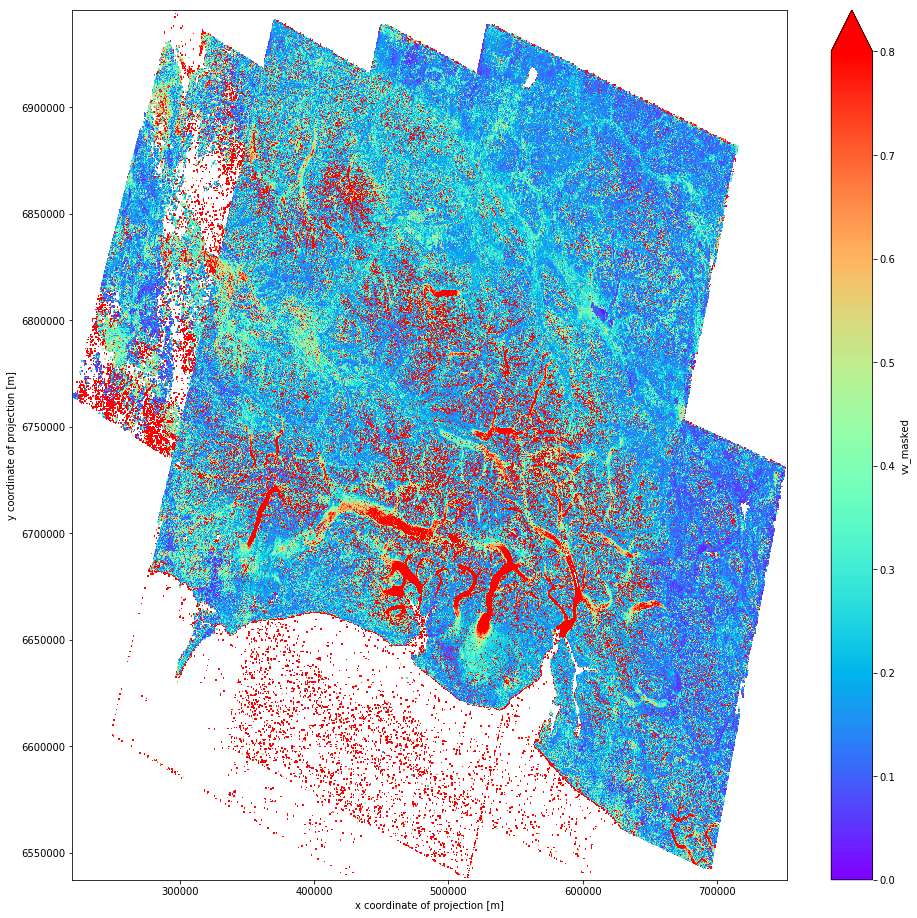

In [13]:
vv_mean2.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=0.8)
# plt.xlim(220000,490000)
# plt.ylim(6700000,6970000)

In [14]:
lgo1=lgo.where(lgo.data < 2.)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [15]:
lgo2=lgo1.mean('time')
lgo3=lgo2.where(lgo2.data < 0.8)         # becomes a mask: Not ocean, at least 20% votes for glacier ice

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


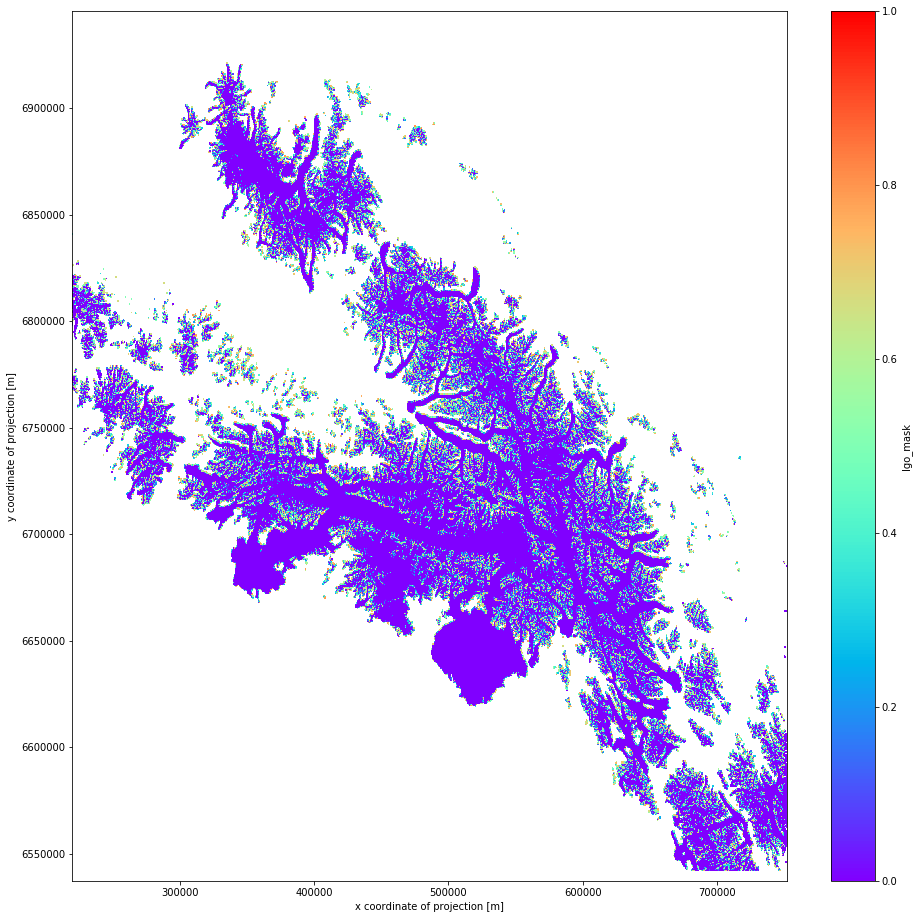

In [16]:
lgo3.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=1.0)

In [17]:
vv_mean3=vv_mean2.where(lgo3.data >= 0.)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


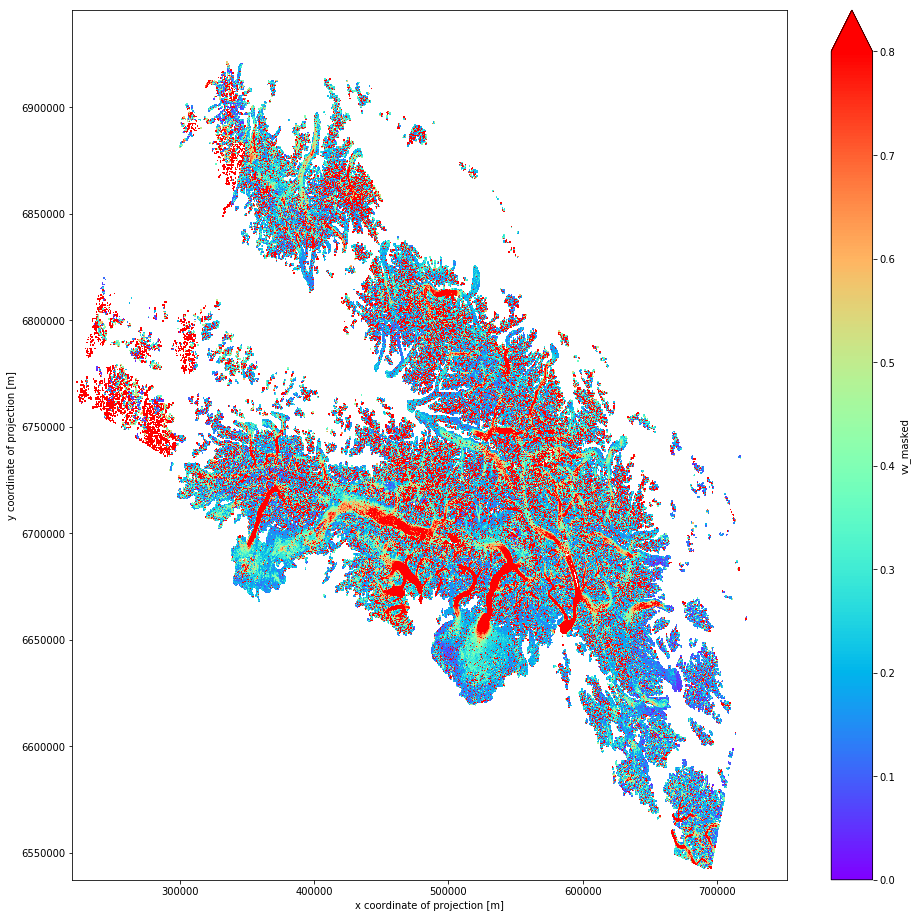

In [18]:
vv_mean3.plot(figsize=(16,16), cmap=plt.cm.rainbow, vmin=0., vmax=0.8)

In [19]:
if False:
    xHi = ds.dims['x'] - 1
    yHi = ds.dims['y'] - 1
    n0 = ds.y[0].data
    n1 = ds.y[yHi].data
    e0 = ds.x[0].data
    e1 = ds.x[xHi].data
    print(e0, e1, n0, n1)
    print(utm.to_latlon(e0, n0, 7, 'V'))
    print(utm.to_latlon(e1, n0, 7, 'V'))
    print(utm.to_latlon(e0, n1, 7, 'V'))
    print(utm.to_latlon(e1, n1, 7, 'V'))

In [20]:
def ls_slope(x,y):
    ''' simple least squares fit slope (degree 1)'''
    return np.polyfit(x, y, 1)[0]

def ls_offset(x,y):
    ''' simple least squares fit offset (degree 0)'''
    return np.polyfit(x, y, 1)[1]

def get_slope(x, y, dim='time'):
    # x = Pixel value, y = a vector containing the date, dim == dimension
    DS1 = xr.apply_ufunc(
        ls_slope, x , y,
        input_core_dims=[[dim], [dim]],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )
    return DS1.rename({'speedfield':'p0'})

def get_intercept(x, y, dim='time'):
    DS2 = xr.apply_ufunc(
        ls_offset, x , y,
        input_core_dims=[[dim], [dim]],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )
    return DS2.rename({'speedfield':'p1'})

In [21]:
# Remove -9999.0 values from the vv DataArray (here they become nan)
vvnan = vv.where(vv.data >= 0.)

vvds=vvnan.to_dataset(name='speedfield')
print(vvds)
vvds['speedfield'].values

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


<xarray.Dataset>
Dimensions:     (time: 75, x: 1773, y: 1361)
Coordinates:
  * time        (time) datetime64[ns] 2014-01-10 ... 2015-01-06
  * x           (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y           (y) float64 6.537e+06 6.538e+06 ... 6.945e+06 6.945e+06
Data variables:
    speedfield  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [22]:
print(vvds.speedfield.sel(y=6710000.,x=500000.,method='nearest').data)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.3805175         nan 0.45239696        nan 0.15132774        nan
        nan 0.19357407        nan 0.05995712        nan        nan
        nan        nan        nan 3.3384483         nan        nan
        nan        nan        nan        nan 0.29603022        nan
        nan 0.25648597        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.3377338         nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]


In [23]:
# Scott configures the source dataset as time-series 2D spatial array of (in time) noisy linear trends
if False:
    # Give each pixel a different set of noise
    nt, ny, nx = 5, 4, 3
    images = np.ones([ny,nx,nt])
    values = np.arange(nt)
    noise = np.random.random([ny,nx,nt])
    # NOTE: more slope variability:
    #cube = (images*values*noise).T
    # alternatively:
    cube = ((images*values) + noise).T

    #time = pd.date_range(start='1950-01-01', periods=nt, freq='10D')
    time = np.arange(nt)
    DA = xr.DataArray(da.from_array(cube, chunks=(1, nx, ny)),
                   dims=('time', 'lat', 'lon'),
                   coords={'time': time})
    DS = DA.to_dataset(name='field')
    print(DS)
    DS['field'].values

In [24]:
if False:
    # I would like a time axis that has decimal time in some familiar unit like 1 day. Why? 
    #   Because when I try to fit a line to the data it complains...
    # Since our time range is 2013 to 2018 we will have values of a couple thousand days; 
    #   but that is pretty reasonable particularly when our data for speed are in meters per day.
    # The first step is to choose some epoch; I used January 1 2013 as prior to all the GOLIVE data.
    # With this epoch in hand we convert from datetime.datetime to np.datetime64.
    # We then reference a datetime in the vvds Dataset, subtract the epoch and convert to (24-hour) units
    dtEpoch = datetime(2013,1,1,0,0,0)
    dt64Epoch = np.datetime64(datetime(2013,1,1,0,0,0))
    ts = (vvds.time[0].data - dt64Epoch) / np.timedelta64(24, 'h')
    print(ts, 'days from Jan 1 2013 to the first timestamp of the Dataset:', vvds.time[0].data)

In [25]:
vvds.coords               # notice time is datetime64; some with hours added to avoid collisions

Coordinates:
  * time     (time) datetime64[ns] 2014-01-10 2014-01-10T01:00:00 ... 2015-01-06
  * x        (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 ... 6.945e+06 6.945e+06

In [26]:
vvds.dims            # 75 source results x (spatial extent)

Frozen(SortedKeysDict({'time': 75, 'x': 1773, 'y': 1361}))

In [27]:
from numpy import datetime64 as dt64, timedelta64 as td64
def ETimeDDays(timeX): return (timeX - dt64(datetime(2013,1,1))) / td64(24, 'h')

vvds['time'] = ('time', [ETimeDDays(atime.data) for atime in vvds.time])

In [30]:
vvds.count()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    speedfield  int64 10364397

In [31]:
vvds

<xarray.Dataset>
Dimensions:     (time: 75, x: 1773, y: 1361)
Coordinates:
  * time        (time) float64 374.0 374.0 376.0 381.0 ... 728.0 733.0 735.0
  * x           (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y           (y) float64 6.537e+06 6.538e+06 ... 6.945e+06 6.945e+06
Data variables:
    speedfield  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

### Remarks

There are two types of `coordinates` in `xarray`: Dimension coordinates (1D, correspond precisely by name to 
their `dimension`, marked by an asterisk (\*) as above; and non-dimension coordinates. These latter contain
coordinate data but are not a dimension coordinate. 

In [32]:
# vvds.assign_coords(dtime=EpochTimeDecimalDays(vvds.time))
# vvds.dtime=vvds.time.
# print(dir(vvds.time[0].data))
# print(vvds.time[0].data)
# print(type(vvds.time[0].data))
# dir(vvds.time)

In [34]:
%%time

dsRob = vvds.chunk(chunks={'time':-1, 'y':400, 'x':400})

CPU times: user 956 ms, sys: 0 ns, total: 956 ms
Wall time: 955 ms


In [35]:
print(dsRob, '\n')
timeseries = dsRob.speedfield
apoint = timeseries.sel(y=6710000.,x=500000.,method='nearest')
print(apoint.data)
print(vvds.speedfield.sel(y=6710000.,x=500000.,method='nearest').data)
# timeseries.plot()
# print(dsRob.speedfield.sel(y=6710000.,x=500000.,method='nearest').data)

<xarray.Dataset>
Dimensions:     (time: 75, x: 1773, y: 1361)
Coordinates:
  * time        (time) float64 374.0 374.0 376.0 381.0 ... 728.0 733.0 735.0
  * x           (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y           (y) float64 6.537e+06 6.538e+06 ... 6.945e+06 6.945e+06
Data variables:
    speedfield  (time, y, x) float32 dask.array<shape=(75, 1361, 1773), chunksize=(75, 400, 400)> 

dask.array<getitem, shape=(75,), dtype=float32, chunksize=(75,)>
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.3805175         nan 0.45239696        nan 0.15132774        nan
        nan 0.19357407        nan 0.05995712        nan        nan
        nan        nan        nan 3.3384483         nan        nan
        nan        nan        nan        nan 0

# Solve LS fit here

In [52]:
lsvel = vvds.speedfield.sel(y=6710000.,x=500000.,method='nearest').data
lstime = vvds['time']
# print(lsvel, '\n\n', type(y), '\n\n', lstime)
lsx = []
lsy = []
for d in range(len(lsvel)):
    if not np.isnan(lsvel[d]): 
        lsx.append(float(lstime[d].data))
        lsy.append(lsvel[d])


print(lsx, lsy)

[431.0416666666667, 438.0416666666667, 447.0416666666667, 463.0, 479.0, 518.0416666666666, 623.0, 646.0416666666666, 687.0416666666666] [0.3805175, 0.45239696, 0.15132774, 0.19357407, 0.05995712, 3.3384483, 0.29603022, 0.25648597, 0.3377338]


In [53]:
np.polyfit(lsx, lsy, 1)

array([-1.83578926e-04,  7.03912562e-01])

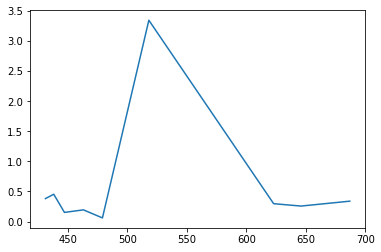

In [56]:
plt.plot(lsx, lsy)

In [61]:
from scipy.signal import medfilt as mf
lsymf = mf(lsy, kernel_size=3)


In [1]:
plt.plot(lsx, lsymf)

NameError: name 'plt' is not defined

In [62]:
print(lsy)
print(lsymf)

[0.3805175, 0.45239696, 0.15132774, 0.19357407, 0.05995712, 3.3384483, 0.29603022, 0.25648597, 0.3377338]
[0.38051751 0.38051751 0.19357407 0.15132774 0.19357407 0.29603022
 0.29603022 0.29603022 0.25648597]


In [66]:
print(np.polyfit(lsx, lsy, 1))
print(np.polyfit(lsx, lsymf, 1))

[-1.83578926e-04  7.03912562e-01]
[1.97819268e-06 2.70525139e-01]


In [65]:
print(np.polyfit(lsx, lsy, 1)[0]*365.25)
print(np.polyfit(lsx, lsymf, 1)[0]*365.25)

-0.06705220258130738
0.0007225348780077195


In [ ]:
plt.plot(lsx, lsymf)
xxx=np.arange(450.,650.)
yyy=xxx*

In [ ]:
    p = m[2].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=lowerColor, vmax=upperColor) # rainbow > bwr blue-white-red
    ax = p.axes
    
    # the first index is the transect index: 0, 1, 2, 3
    for j in range(4): 
        xxx = [seward_utm0[j][0] + float(i)*tpS[j][0] for i in range(npS[j])]
        yyy = [seward_utm0[j][1] + float(i)*tpS[j][1] for i in range(npS[j])]
        ax.plot(xxx, yyy, 'k')

In [36]:
%%time

dsRob1 = get_slope(dsRob.time, dsRob, 'time').compute()

# def get_slope(x, y, dim='time'):
    # x = Pixel value, y = a vector containing the date, dim == dimension
    # DS1 = xr.apply_ufunc(
        # ls_slope, x , y,
        # input_core_dims=[[dim], [dim]],
        # vectorize=True, 
        # dask='parallelized',
        # output_dtypes=[float],
        # )
    # return DS1.rename({'speedfield':'p0'})

CPU times: user 7min 27s, sys: 1min 17s, total: 8min 45s
Wall time: 6min 28s


In [37]:
dsRob1

<xarray.Dataset>
Dimensions:  (x: 1773, y: 1361)
Coordinates:
  * x        (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 ... 6.945e+06 6.945e+06
Data variables:
    p0       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [38]:
print(dsRob1.p0.sel(y=6710000.,x=500000.,method='nearest').data)

nan


<xarray.DataArray 'p0' (y: 1361, x: 1773)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 2.2e+05 2.203e+05 2.206e+05 ... 7.513e+05 7.516e+05
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 ... 6.945e+06 6.945e+06


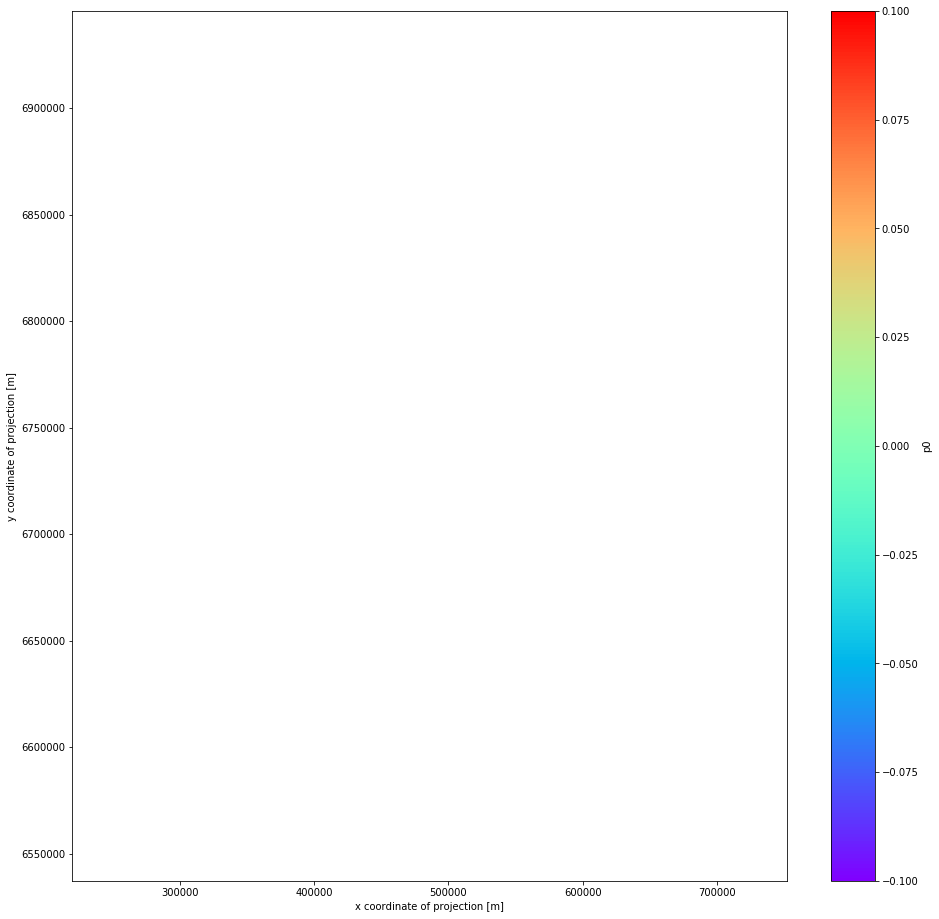

In [39]:
p0=dsRob1.p0
print(p0)
p0.plot(figsize=(16,16), cmap=plt.cm.rainbow) # , vmin=-.001, vmax=0.001)

In [40]:
print(p0.sel(y=6700000.,x=500000.,method='nearest').data)

nan


In [41]:
# dsScott = DS.chunk(chunks={'time':-1, 'lat':3, 'lon':2})
# dsScott1 = get_slope(dsScott.time, dsScott, 'time').compute()

# Get intercept as well
# dsScott2 = get_intercept(dsScott.time, dsScott, 'time').compute()

# Can merge these into a single datasets
# R = xr.merge([dsScott1,dsScott2])

# Plot the results to make sure things look okay
# So to plot points and line:
# def plot_pixel(x=0,y=0):
#     data = dsScott['field'].isel(dict(lon=x,lat=y)).compute()
    #print(data)
#     coef = R.isel(dict(lon=x,lat=y)).to_array().values
    #print(coef)
#     plt.title(f'Lon={x} Lat={y}')
#     plt.scatter(data.time.values, data.values, label='data')
#     plt.plot(data.time.values, np.polyval(coef, data.time.values), label='fit')
#     plt.legend()

# plot_pixel(0,1)

# dsScott1.p0.plot.imshow()
# plt.title('Slope map')

NameError: name 'DS' is not defined

## Learning xarray/dask basics

In [ ]:
# This cell follows Scott Henderson's example to create a bunch of linear trends in time
#   across a 2D spatial grid, roughed up with a bit of noise.

nt = 10                                # Ten elements in the time dimension
nx = 6                                 #     Six in the x
ny = 7                                 #     Seven in the y

images = np.ones([ny,nx,nt])           # A 3D numpy array of ones: Fast index is time (10), slow is y (7)
values = np.arange(nt)                 # A list[] of floats 0., 1., ..., 9.
noise = np.random.random([ny,nx,nt])   # A 3D numpy array of uniform random values on [0., 1.]
                                       #   which would be indexed via [a, b, c]; not [a][b][c]

cubeStart = (images*values)            # A 3D numpy array where the fast index (time) goes 0, 1, ..., 9
                                       #   This uses 'broadcast multiplication' element-by-element along
                                       #   the fast (right-most) index. What if values[] has length nx or ny? 
                                       #   Answer: This is no good, won't work. The broadcast list must match 
                                       #   the fast index in length.
cubeNext = cubeStart + noise           # Element-by-element addition of the [0, 1] noise tensor
cube = cubeNext.T                      # .T is Transpose: Now the fast index is time, then follows x, then y
# print(cubeStart)

# hold cube2 in reserve for later: The idea of adding a new DataArray to an existing Dataset
cube2 = ((images*values) + noise + noise + noise).T

In [ ]:
# import dask is necessary to work with dask.array objects 
tlist = np.arange(nt)
xlist = np.arange(0., nx*2., 2.)
ylist = np.arange(0., ny*3., 3.)
aDaskArray = dask.array.from_array(cube, chunks=(nt, 1, 1))
print(aDaskArray[7,4,2])
aDaskArray

In [ ]:
da = xr.DataArray(aDaskArray,
                  dims=('tt', 'xx', 'yy'),
                  coords={'tt': tlist, 'xx': xlist, 'yy': ylist})
print('Describe the DataArray:\n', da, '\n')
print('Regarde: The data do not print; they just indicate a dask array:\n', da.data, '\n')

In [ ]:
dads=da.to_dataset(name='speedfield')

# dir(dads)          # this gives a long listing that includes attrs, dims, coords, data_vars as elements of.
                     #   We see these listed prominently when we print the Dataset. 
print('attributes:', dads.attrs, '\n')
print('coords:', dads.coords, '\n')
print('dimensions:', dads.dims, '\n')
print('data_vars:', dads.data_vars, '\n')
print('No append method in the data_vars:\n', g.dirnou(dads.data_vars), '\n')
for dv in dads.data_vars: print(dv)
print('\n')
# print(type(dads.attrs))
# print(type(dads.coords))
# print(type(dads.dims))
# print(type(dads.data_vars))
print(type(dads.tt))
print(dads.tt.data)
print('\n')

# To see the vast composition of a Dataset (state attributes and methods) use 'print(dir(dads))'.
# The next cell elaborates all of this content for the dads Dataset.


### The Dataset summarized

`print(dir(dads))` produces a vast list of state attributes and method attributes (110 of them!)
These are sorted out here as an exercise in gaining familiarity with xarray Datasets. At the top level 
a Dataset is composed of four objects:

- An OrderedDict of attributes
- Dataset coordinates: Analogous to a key:value Dictionary of DataArrays.
- Dataset dimensions (which are 'Frozen')
- DataVariables containing data distributed across some of these dimensions, optionally using the coordinates


These four objects are instances of four classes; so each has its own attributes; and 
so on down into various weeds. At the moment we are interested in this high level of the `dads` Dataset: 
I indicate methods in what follows using `.method(arg[s])` with some examples.  


#### Related terminology

- Python Mapping is an important construct in the design of this machinery (stub remark).
- methods: method functions are declared within a class with an explicit first argument representing that 
object (the Dataset) which is provided implicitly by the method call; so the method has access to the 
entirety of the Dataset object, referring to it as `self`.
- `xr.DataArray` also has four components: `values`, `dims`, `coords`, and `attrs`. `dims` are analogous to
an `axis` in numpy. (A DataArray can also optionally be assigned a `name`: `fu = xr.DataArray(data=3, name='bar')`.
- `dask` builds graph representations for dynamic task scheduling needed to perform out-of-core computations. It mimics `Pandas` DataFrames by having its own DataFrames and likewise mimics the `np.ndarray` via `dask.array`; with the 
user-crucial addition of the concept of the chunk. 

In [ ]:
rdata = np.random.rand(4, 3)                        # a 2D ndarray of random values with dimensions as given
locs = ['IA', 'IL', 'IN']                           # three state abbreviations
times = pd.date_range('2000-01-01', periods=4)      # default period is 1 day 
foo = xr.DataArray(rdata, coords=[times, locs],      # first argument is always the data
    dims=['time', 'space'], name='Amelia',          # This name Amelia associates with the data, not the DataArray object
    attrs={'Here': 'We', 'Include': 'Metatada',
          'Attributes': 'As a dictionary'})
                   
foo.attrs['throw in'] = 'some meters'

foo = foo.rename('AmeliaB')                         # 'rename()' returns a new DataArray without modifying foo
                                                    #   so we re-assign the new object to foo
foo                                                 # notice that 'rdata' is not mentioned but AmeliaB is

In [ ]:
fubar=foo.to_dataset(dim='time')
fubar1 = foo.to_dataset(name='yawlp')
print(fubar, '\n')                        # The DataArray is broken apart in the 'time' dimension to produce
                                          #   a series of Data variables in the Dataset (using time coordinates)
print(fubar1)                             # AmeliaB becomes yawlp

In [ ]:
# from the fubar dataset with two coordinates 'space' and 'time': We continue by adding both
#   some Data variables and some Coordinates (which in some cases add dimensions).

# Add two Data variables
fubar['temp'] = (('time', 'space'), np.random.rand(4, 3))
fubar['precip'] = (('space', 'time'), np.random.rand(3,4)*5.)

######
#
# Now change gears: What follows applies to coords and dims; this is no longer Data variable territory
#
#####

# Add two coordinates that will be non-dimensional
fubar.coords['lat'] = ('latitude', np.arange(24.))               # implicitly declares dimension latitude
fubar.coords['lon'] = ('longitude', np.arange(18.))              #   and longitude. Since these are not the
                                                                 #   same as the coordinate names 'lat' and 'lon'
                                                                 #   these coords are 'non-dimension coordinates'


# As there are not coords matching dims 'latitude' and 'longitude' they become 'dimensions without coordinates'.
# 'time' is another DWC as it was devalued when fubar was created with: fubar=foo.to_dataset(dim='time'). 
# Since this broke the AmeliaB data by time into multiple DataArrays there was no longer a time dimension.


# Add a coordinate that is dimensional, having coordinate name = dimension name
fubar.coords['q'] = (('q', [1.4]))
fubar.coords['q2'] = 1.5                                         # single value does not imply and therefore 
                                                                 #   fails to create dimension 'q2'
fubar.coords['moped'] = np.arange(5)                             # multiple values imply and create dimension 'moped'
fubar.coords['reference_time'] = pd.Timestamp('2014-09-05')      # Single value: No dimension implied
fubar.coords['dope'] = pd.date_range('2000-01-01', periods=4)    # Multiple values: Dimension of same name implied

######
#
# Now change gears again: This is modification and addition to attrs
#
#####

fubar.attrs['throwing in'] = 'another attribute'
fubar.attrs['Here'] = 'is change! But do not fail to'

fubar

### Continuing with `dads` attributes (methods and state variables)

#### State attributes specific to this particular *`dads`* Dataset


- `tt, xx, yy` are both coordinates and dimensions within `dads`. In this context they are *coordinates*, not *dimensions*.
- `speedfield` is a Data variable within `dads`

In [ ]:
'tt' in dads and 'speedfield' in dads # prints True

#### Modify Dataset structure

- set_coords(string or list of strings)             migrates named Data variable(s) into Coordinates


#### Selection and comparison methods


- where()
- any()
- all()
- isel()
- sel()


#### Format and file methods

- to_array
- to_dask_dataframe
- to_dataframe
- to_dict
- to_netcdf
- to_zarr
- load

#### `dask.array` chunking

- chunk
- chunks


#### four categories of content of a Dataset (objects with their own attributes)

- .attrs
- .coords
- .data_vars
- .dims


#### assessing content

- count


#### selecting content



#### Sir Not-yet-summarized methods

- apply
- argmax
- argmin
- argsort
- assign
- assign_attrs
- assign_coords
- astype
- bfill
- broadcast_equals
- clip
- close
- combine_first
- compute
- conj
- conjugate 
- copy
- cumprod
- cumsum
- diff
- differentiate
- drop
- dropna
- dump_to_store
- encoding
- equals
- expand_dims
- ffill
- fillna
- filter_by_attrs
- from_dataframe
- from_dict
- get
- get_index
- groupby
- groupby_bins
- identical
- imag
- indexes
- info
- interp
- interp_like
- interpolate_na
- isel_points 
- isin
- isnull
- items
- keys
- load_store
- loc
- max
- mean
- median
- merge
- min
- nbytes
- notnull
- persist
- pipe
- prod
- quantile
- rank
- real
- reduce
- reindex
- reindex_like
- rename() will rename Data variables returning a new Dataset; not 'in place'
- reorder_levels
- resample
- reset_coords
- reset_index
- roll
- rolling
- round
- sel_points
- set_index
- shift
- sizes
- sortby
- squeeze
- stack
- std
- sum
- swap_dims() swaps a dimensional for a non-dimensional coordinate
- transpose
- unstack
- update
- values
- var
- variables

In [ ]:
# In top down order: 
#   We have a 'data array data set' dads: DataSet(One DataArray named 'speedfield')
#     This has a 'tt' dimension and an associated 'tt' coordinate. 
#     The 'tt' coordinate is a DataArray with 10 int64 values
#     Using the .data extension to this the coordinate gives an np.ndarray.
#     This prints as a space-delimited array (not a comma-delimited list)
#     At need it could be converted to a list using .tolist()
# 
print('the tt coordinate data type is:', type(dads.tt.data))
print('the tt coordinate data describes itself:', dads.tt.data)
print('the tt coordinate self-identifies as:', dads.tt)
print('type of the tt coordinate is:', type(dads.tt))
print('converting the coordinate data to a list:', dads.tt.data.tolist())

In [ ]:
# The dads Dataset itself has just the one Data variable 'speedfield'.
#   This is also a DataArray; indexed by three dimensional indices
#   
print('dads Dataset:', dads, '\n')
print('dads.speedfield has type:', type(dads.speedfield), '\n')
print('speedfield with indices 1, 2, 3 (tt, xx, yy) is a DataArray:\n', dads.speedfield[1,2,3],'\n')
print('speedfield data value at same:\n', float(dads.speedfield[1,2,3]),'\n')
print('(speedfield with indices 10, 2, 3 (tt, xx, yy) fails with dimension 0 out of bounds)\n')

for a in dads.speedfield[1,:,3]: print(float(a))

print([float(a) for a in dads.speedfield[:,2,3]])
print([float(a) for a in dads.speedfield[1,:,3]])
print([float(a) for a in dads.speedfield[1,2,:]])
# print('speedfield along the x axis:\n', float(dads.speedfield[1,:,3]))

In [45]:
y=np.arange(0.,30.,3); print(y)
np.polyfit(dads.tt.data, y, 1)

s = vvds.speedfield.sel(y=6710000.,x=500000.,method='nearest').data
s.shape

y=np.arange(0.,75.)
np.polyfit(s,y,1)

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


NameError: name 'dads' is not defined

In [ ]:
dads1 = xr.Dataset({'tempo': (['x', 'y', 'time'],  temp),
   ....:                  'precipitation': (['x', 'y', 'time'], precip)},
   ....:                 coords={'lon': (['x', 'y'], lon),
   ....:                         'lat': (['x', 'y'], lat),
   ....:                         'time': pd.date_range('2014-09-06', periods=3),
   ....:                         'reference_time': pd.Timestamp('2014-09-05')})